# Convolve a simulated image wit the XMM PSF

In [30]:
from astropy.io import fits
from astropy.convolution import convolve, convolve_fft

from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u

import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

import aplpy

from photutils import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry

In [27]:
wdir = '/home/ivaltchanov/XMM/Clusters/a1795/0097820101/xmmsas_20180620_1732-17.0.0'
hdu1 = fits.open(wdir + '/pn_500_7000_simulated.fits')
psf = fits.open(wdir + '/pn_psf.fits')

In [74]:
wcs = WCS(hdu1[0].header)
arcmin2pix = wcs.pixel_scale_matrix[1,1]*60.0
center = SkyCoord(207.2208333,26.59027778,unit=(u.deg,u.deg),frame='icrs')
aperture2 = SkyCircularAperture(center, r=2. * u.arcmin)
aperture4 = SkyCircularAperture(center, r=4. * u.arcmin)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [75]:
# grid to mask the outside area
rmask = 1.0 # arcmin, the cool core scale
nx,ny = hdu1[0].data.shape
y, x = np.mgrid[0:ny, 0:nx]
xy = wcs.wcs_world2pix(center.ra.value,center.dec.value,1)
y = y - xy[1]
x = x - xy[0]
rx = np.sqrt(x*x + y*y)
rmax = rmask/arcmin2pix
ix = np.where(rx >= rmax)
image_mask = hdu1[0].data.copy()
image_mask[ix] = 0.0

In [76]:
photo2 = aperture_photometry(hdu1[0].data, aperture2,wcs=wcs)
photo4 = aperture_photometry(hdu1[0].data, aperture4,wcs=wcs)
ap_flux2 = photo2['aperture_sum'][0]
ap_flux4 = photo4['aperture_sum'][0]
annulus = ap_flux4 - ap_flux2
print ("Total flux in aperture4: {}".format(ap_flux4))
print ("Total flux in aperture2: {}".format(ap_flux2))
print ("Total flux in annulus: {}".format(annulus))
ratio = ap_flux2/annulus
print ("Ratio center to annulus: {}".format(ratio))

Total flux in aperture4: 1270090.768441915
Total flux in aperture2: 848094.5693142086
Total flux in annulus: 421996.19912770647
Ratio center to annulus: 2.0097208720535282


In [77]:
result = convolve_fft(image_mask,psf[0].data)

/home/ivaltchanov/miniconda3/envs/py355/lib/python3.5/site-packages/astropy/convolution/convolve.py:670: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/home/ivaltchanov/miniconda3/envs/py355/lib/python3.5/site-packages/astropy/convolution/convolve.py:676: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = normalized_kernel
/home/ivaltchanov/miniconda3/envs/py355/lib/python3.5/site-packages/astropy/convolution/convolve.py:692: FutureWarning: Using a non-tuple sequence for multidimensional in

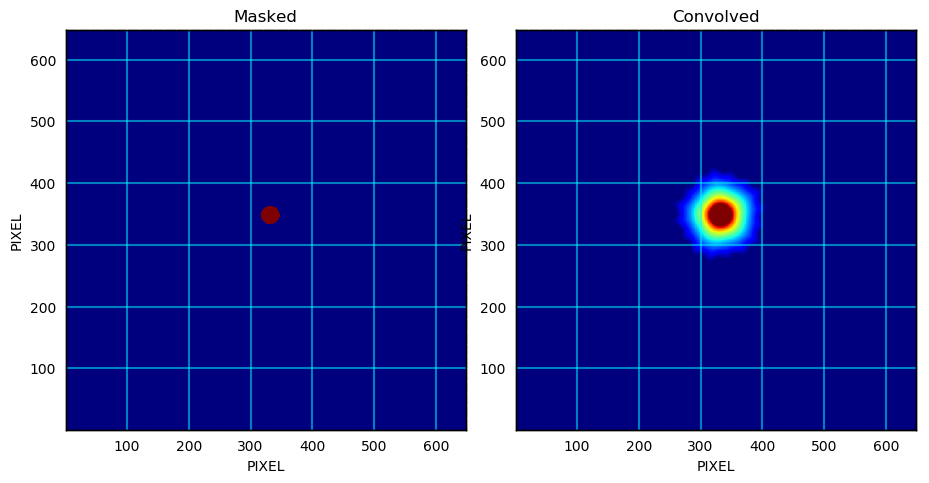

In [78]:
fig = plt.figure(figsize=(10,10),dpi=100)
f0 = aplpy.FITSFigure(image_mask, figure=fig, subplot=[0.1,0.1,0.4,0.4])
f0.show_colorscale(vmin=1,vmax=100,stretch='log')
f0.set_title('Masked')
f0.add_grid()
f0.grid.set_color('cyan')
f0.grid.set_alpha(0.5)
f1 = aplpy.FITSFigure(result, figure=fig, subplot=[0.55,0.1,0.4,0.4])
f1.show_colorscale(vmin=1,vmax=100,stretch='log')
f1.set_title('Convolved')
f1.add_grid()
f1.grid.set_color('cyan')
f1.grid.set_alpha(0.5)
#f0.show_circles(aperture1.positions.ra.value,aperture1.positions.dec.value,\
#                    aperture1.r.value/60.0,edgecolor='black')
#f0.show_circles(aperture2.positions.ra.value,aperture2.positions.dec.value,\
#                    aperture2.r.value/60.0,edgecolor='blue')
#f0.recenter(aperture.positions.ra.value,aperture.positions.dec.value,radius=8.0/60.0)
#f0.show_markers(aperture.positions.ra.value,aperture.positions.dec.value)
#f0.tick_labels.set_xformat('hh:mm:ss.s')
#f0.tick_labels.set_yformat('dd:mm:ss')
#f0.hide_ytick_labels()
#f0.hide_xtick_labels()
#

In [81]:
#
# after convolution
#
photo2x = aperture_photometry(result, aperture2,wcs=wcs)
photo4x = aperture_photometry(result, aperture4,wcs=wcs)
ap_flux2x = photo2x['aperture_sum'][0]
ap_flux4x = photo4x['aperture_sum'][0]
annulsx = ap_flux4x - ap_flux2x
print ("Total flux in aperture4: {}".format(ap_flux4x))
print ("Total flux in aperture2: {}".format(ap_flux2x))
print ("Total flux in annulus: {}".format(annulsx))
print ("Total flux in annulus to center: {}".format(annulsx/ap_flux2x))
print ("Ratio of center to annulus flux to center: {}".format(annulsx/ap_flux2x))
print ("Ratio to original flux in the ring: {}".format(annulsx/annulus))

Total flux in aperture4: 450354.33820036525
Total flux in aperture2: 407870.50309725024
Total flux in annulus: 42483.83510311501
Total flux in annulus to center: 0.10416010665273683
Ratio of center to annulus flux to center: 0.10416010665273683
Ratio to original flux in the ring: 0.10067350177781662
